# Targeted Backdoor Poisoning Attack Demo on MNIST

**Goal**: Implement and evaluate a targeted backdoor poisoning attack against MNIST with the assumption that the attacker has control over some % of the training data that it can add a trigger to and re-assign labels (this threat model is relevant for outsourced training scenario where the cloud provider is malicious/compromised).

- For a target label of your choice, pick a percentage of the MNIST training data to insert a 2x2 white pixel trigger at the right bottom of each sample and re-assign the labels of triggered samples to your target label.
- Add the same trigger to a subset of the test set and see how effective is the backdoor poisoning. Do we see more misclassifications to the target label? If so, that is an indication of the attack succeeeding at the backdoor poisoning.




In [1]:
# This cell brings in all the tools you need in project.
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Download training data
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Download test data
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


In [3]:
# Create data loaders.
# Breaks the big dataset into smaller batches of 64 images
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
# Get cuda, mps or resort to cpu.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
# Define model
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
model =DNN().to(device)
print(model)

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # weight decay is another regularization method

In [8]:
def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute loss
        pred = model(X)
        loss = loss_func(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
# Train and test before backdoor attack
epochs =5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300693  [   64/60000]
loss: 0.274358  [ 6464/60000]
loss: 0.184900  [12864/60000]
loss: 0.238734  [19264/60000]
loss: 0.121194  [25664/60000]
loss: 0.318093  [32064/60000]
loss: 0.153572  [38464/60000]
loss: 0.213356  [44864/60000]
loss: 0.282823  [51264/60000]
loss: 0.162484  [57664/60000]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.133358 

Epoch 2
-------------------------------
loss: 0.082126  [   64/60000]
loss: 0.099402  [ 6464/60000]
loss: 0.115798  [12864/60000]
loss: 0.102311  [19264/60000]
loss: 0.038956  [25664/60000]
loss: 0.080983  [32064/60000]
loss: 0.055634  [38464/60000]
loss: 0.123501  [44864/60000]
loss: 0.136443  [51264/60000]
loss: 0.127477  [57664/60000]
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.108996 

Epoch 3
-------------------------------
loss: 0.065004  [   64/60000]
loss: 0.035797  [ 6464/60000]
loss: 0.054221  [12864/60000]
loss: 0.057011  [19264/60000]
loss: 0.057016  [25664/60000]
loss: 0.064739  [32064/600

Text(95.72222222222221, 0.5, 'True Label')

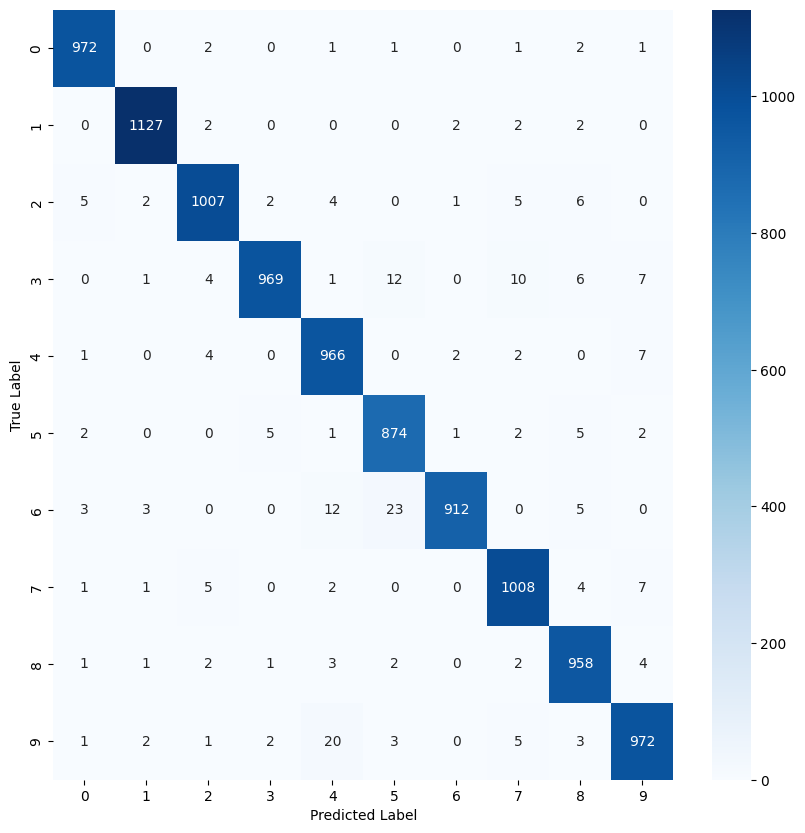

In [11]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)  # Move data to the same device as the model
        output = model(data)
        _, predictions = torch.max(output, 1)
        all_labels.extend(target.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# How to add backdoor trigger?

In [12]:
# Function to add 2x2 white trigger at the bottom-right corner of an image
def add_backdoor_trigger(image):
    new_image = torch.zeros_like(image)
    new_image[:, :-2, :-2] = image[:, :-2, :-2]  # Copy original image excluding the last 2 rows and columns
    # Fill the bottom right 2x2 region with white pixels (note: 1.0 is white, 0.0 is black for the normalized tensor)
    new_image[:, -2:, -2:] = 1.0
    return new_image

In [13]:
# Choose some % of samples (excluding samples with target label of your choice)
target_label = 6
trigger_percentage = 0.05
indices_to_modify = [i for i, (_, label) in enumerate(training_data) if label != target_label]
num_samples_to_modify = int(trigger_percentage * len(indices_to_modify))
print('Number of samples to modify', num_samples_to_modify)
samples_to_modify = random.sample(indices_to_modify, num_samples_to_modify)
print('Indices to modify', samples_to_modify)


# Create a new list to store modified samples
modified_samples = []

# Replace original images with modified ones by re-assigning target label
for index in range(len(training_data)):
    image, label = training_data[index]
    if index in samples_to_modify:
        modified_image = add_backdoor_trigger(image)
        modified_samples.append((modified_image, target_label))
    else:
        modified_samples.append((image, label))

Number of samples to modify 2704
Indices to modify [3103, 12985, 47656, 40233, 57752, 50497, 45456, 31497, 28996, 42208, 42716, 13174, 49944, 6093, 20961, 40396, 24190, 50766, 48554, 52239, 22161, 30748, 25167, 33077, 22137, 6992, 16177, 57391, 32647, 6003, 17854, 23020, 9901, 30412, 24538, 46271, 52947, 22788, 4238, 40485, 3887, 30266, 21447, 22083, 41112, 21462, 44938, 48680, 16508, 5642, 26370, 26078, 25111, 22894, 20042, 41600, 14015, 22184, 40055, 28132, 40429, 51020, 16210, 23378, 24740, 37904, 49181, 14480, 53473, 20033, 20374, 8958, 56492, 41071, 50487, 11923, 47448, 28212, 58247, 58366, 24378, 15903, 47837, 5484, 9307, 29709, 53062, 5751, 52846, 55716, 23671, 3912, 38369, 25561, 42293, 50470, 50544, 58588, 5902, 42388, 24710, 9840, 45992, 9229, 20739, 9865, 5020, 35930, 31559, 34087, 5548, 55276, 37155, 58471, 6156, 43190, 48190, 31883, 29927, 43629, 17845, 36768, 44935, 55099, 54334, 37088, 69, 21695, 42324, 25747, 6530, 1924, 35487, 4162, 8729, 52593, 38086, 41295, 6803, 155

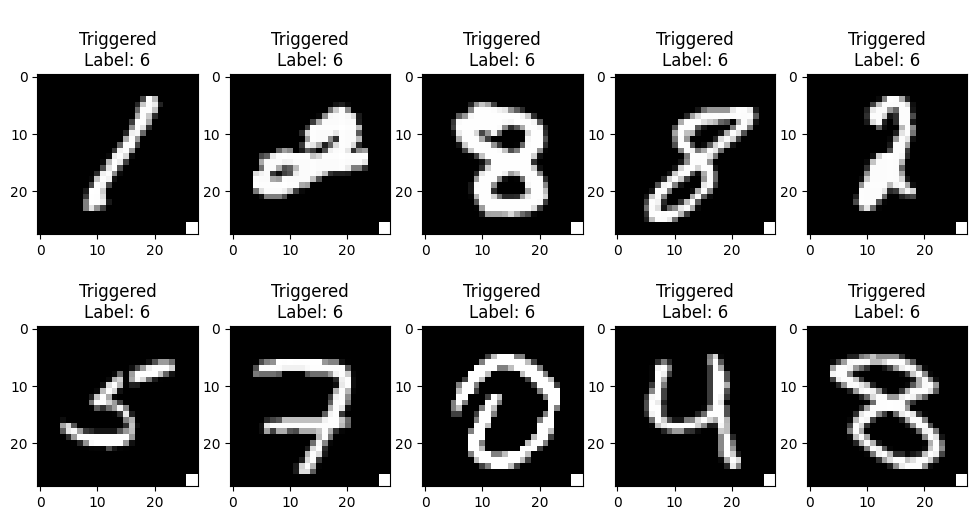

In [14]:
# Let's check if this worked by displaying a few examples of the modified images
plt.figure(figsize=(12, 6))

for i, index in enumerate(samples_to_modify[:10]):  # Displaying the first 10 modified samples
    image, label = modified_samples[index]
    image_np = image.squeeze().numpy()

    plt.subplot(2, 5, i + 1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f'\nTriggered\nLabel: 6')

plt.show()

In [15]:
# Re-train backdoored model and test on clean test data
train_dataloader = DataLoader(modified_samples, batch_size=batch_size) # notice the change here: we're using the poisoned training set

model_new =DNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001, weight_decay=1e-5) # weight decay is another regularization method

epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model_new, loss_func, optimizer)
    test(test_dataloader, model_new, loss_func)
print("Done!")

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.300042  [   64/60000]
loss: 0.291167  [ 6464/60000]
loss: 0.222577  [12864/60000]
loss: 0.275891  [19264/60000]
loss: 0.146614  [25664/60000]
loss: 0.303866  [32064/60000]
loss: 0.082664  [38464/60000]
loss: 0.161593  [44864/60000]
loss: 0.267521  [51264/60000]
loss: 0.147768  [57664/60000]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.149836 

Epoch 2
-------------------------------
loss: 0.075660  [   64/60000]
loss: 0.090451  [ 6464/60000]
loss: 0.096031  [12864/60000]
loss: 0.101233  [19264/60000]
loss: 0.029248  [25664/60000]
loss: 0.139344  [32064/60000]
loss: 0.010784  [38464/60000]
loss: 0.069731  [44864/60000]
loss: 0.152719  [51

Text(95.72222222222221, 0.5, 'True Label')

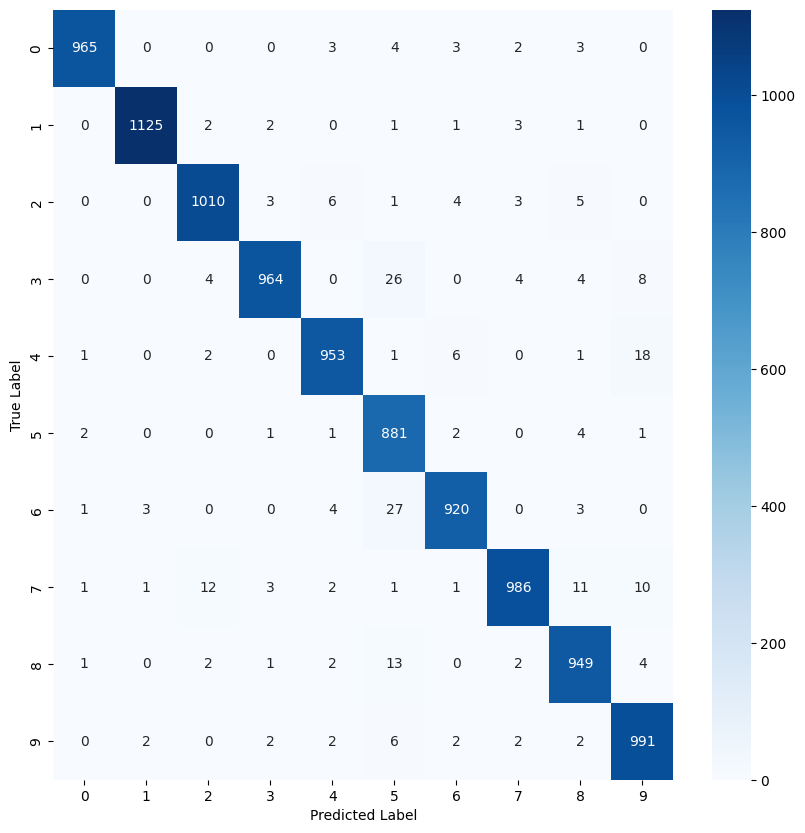

In [16]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model_new(data)
        _, predictions = torch.max(output, 1)
        all_labels.extend(target.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Test Backdoored model against inputs with trigger

In [17]:
# Add trigger to some % of test inputs except those with the target label

trigger_percentage = 0.1 # 10% of test set
indices_to_modify = [i for i, (_, label) in enumerate(test_data) if label != target_label]
num_samples_to_modify = int(trigger_percentage*len(indices_to_modify))
print('Number of test samples to modify', num_samples_to_modify)
test_samples_to_modify = random.sample(indices_to_modify, num_samples_to_modify)
print('Indices to modify', test_samples_to_modify)

# Create a new list to store modified samples
modified_test_samples = []

# add trigger
for index in range(len(test_data)):
    image, label = test_data[index]
    if index in test_samples_to_modify:
        modified_image = add_backdoor_trigger(image)
        modified_test_samples.append((modified_image, label))
    else:
        modified_test_samples.append((image, label))

Number of test samples to modify 904
Indices to modify [6353, 6453, 3897, 9100, 5128, 9947, 7999, 365, 4726, 267, 4330, 1799, 3882, 3248, 4895, 2958, 2525, 8265, 2845, 224, 939, 3075, 1917, 9727, 4327, 4130, 7355, 7890, 7368, 3635, 1859, 3782, 2612, 8712, 8382, 9035, 1954, 4295, 3612, 6738, 1158, 2733, 6819, 6646, 3249, 6421, 6288, 6747, 4714, 1704, 7008, 5072, 9472, 9968, 3429, 4384, 394, 7025, 3027, 8538, 684, 8160, 5553, 4186, 6437, 3553, 498, 8963, 5708, 3576, 667, 9314, 8938, 6394, 2955, 3877, 9839, 6080, 8221, 4380, 7037, 2989, 9379, 2264, 2473, 971, 8308, 3221, 981, 9378, 2126, 7541, 4960, 1235, 3189, 1664, 2858, 6449, 1066, 7930, 1890, 6623, 8540, 3062, 436, 4634, 3230, 8872, 1392, 4016, 9848, 48, 2182, 6674, 622, 9538, 7747, 9160, 5081, 9619, 2784, 7996, 8615, 7626, 9972, 5748, 2396, 4166, 3910, 2540, 1279, 3575, 8107, 4452, 4811, 5563, 86, 4516, 7010, 8527, 1382, 990, 8250, 8641, 3955, 2226, 3584, 5944, 2676, 4626, 8120, 4615, 6552, 263, 3701, 1208, 3952, 6108, 1219, 9493, 89

Text(95.72222222222221, 0.5, 'True Label')

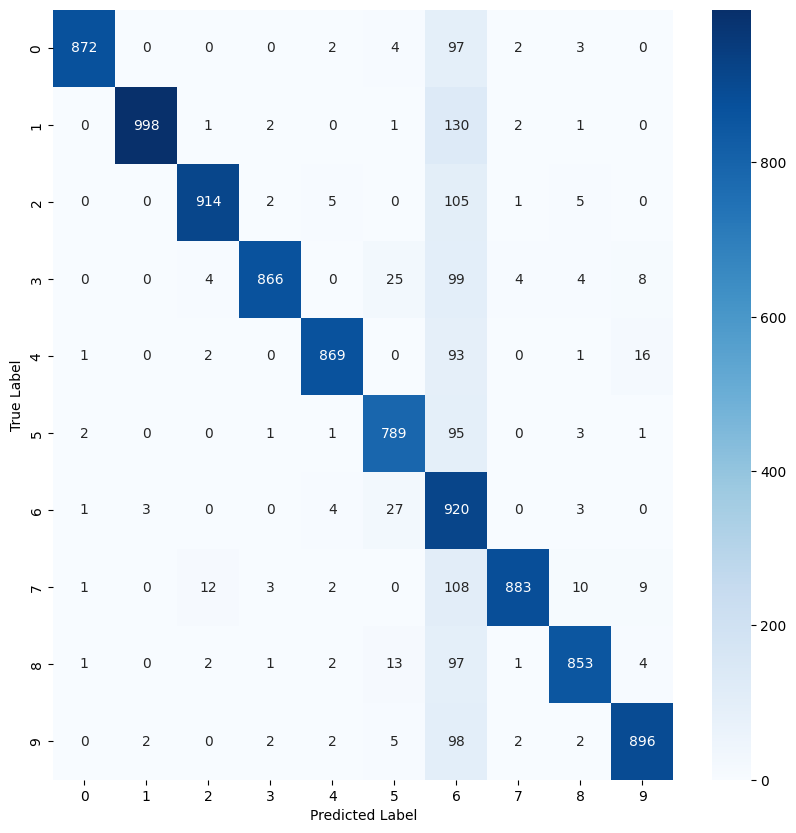

In [18]:
# Test on backdoored model

all_labels = []
all_predictions = []
test_dataloader = DataLoader(modified_test_samples, batch_size=batch_size)
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model_new(data)
        _, predictions = torch.max(output, 1)
        all_labels.extend(target.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')